# Urban Hot Spot analysis

**NOTE**: In Ouagadougou (Burkina Faso), the "rural" area is bare laterite soil and dry brush. In the hot season, this heats up faster than the city (see Lindén, 2011; Offerle et al., 2005). We should probably use a different approach to Hoang et al. 2025, since the rural areas are actualy hotter than the urban areas during the day. We might consider, for example, using an intra-urban heat comparison between pixels (Lindén, 2011).


**References**

Lindén, J. (2011). "Nocturnal Cool Island in the Sahelian city of Ouagadougou, Burkina Faso." International Journal of Climatology, 31(4), 605–620. DOI: 10.1002/joc.2145

Offerle, B., Jonsson, P., Eliasson, I., & Grimmond, C.S.B. (2005). "Urban Modification of the Surface Energy Balance in the West African Sahel: Ouagadougou, Burkina Faso." Journal of Climate, 18(19), 3983–3995. DOI: 10.1175/JCLI3520.1

# Import libraries

In [1]:
import ee
import geemap
import geemap.colormaps as cm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML


# Initialize Google Earth Engine
# ee.Authenticate()
ee.Initialize()

/Users/helyne/.pyenv/versions/climatematch/lib/python3.13/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# 1. Load urban area

In [2]:
# ==========================================================
# 1. LOAD URBAN AREA (OUAGADOUGOU)
# ==========================================================

# Load the Ouagadougou urban boundary
urban_fc = ee.FeatureCollection("projects/ee-helyne/assets/Ouaga_boundary")
urban = urban_fc.geometry()


# Define some helper functions

In [3]:
# ==========================================================
# HELPER FUNCTION TO PROCESS LANDSAT IMAGES
# ==========================================================

# Compute LST in Celsius & bit-wise cloud masking
def process_landsat(img):
    # Scale factors for Collection 2 Level 2
    # ST_B10 is Surface Temperature in Kelvin. Scale: 0.00341802, Offset: 149.0
    lst_kelvin = img.select('ST_B10').multiply(0.00341802).add(149.0)
    
    # Convert to Celsius
    lst_celsius = lst_kelvin.subtract(273.15).rename('LST')
    
    # QA Masking (Bit 6 is 'Clear', Bit 8 is 'Cloud Shadow', Bit 9 is 'Cloud')
    # We strictly want clear pixels
    # 1 << 6 checks bit 6 and `.neq(0)` means "is not zero" (i.e., is 1)
    qa = img.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 6).neq(0) 
    
    return lst_celsius.updateMask(mask).copyProperties(img, ['system:time_start'])


In [4]:
# Simple function to count images per month (for sanity checking)
def count_images_per_month(base_collection):
    # Define month names for labeling
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Loop through each month (1-12)
    for month in range(1, 13):
        # Filter to just this calendar month (across both years)
        monthly_collection = base_collection.filter(
            ee.Filter.calendarRange(month, month, 'month')
        )
        
        # Check if there are images for this month
        count = monthly_collection.size().getInfo()
        if count == 0:
            print(f"No images for {month_names[month-1]}, skipping...")
            continue
        
        print(f"{month_names[month-1]}: {count} images, ")

# Process images and visualize LST maps

In [5]:
# Select time period
start_year = 2022
whole_year = False
start_month, end_month = ("01", "12") if whole_year else ("03", "05") 

In [6]:

# ==========================================================
# 2. LOAD LANDSAT-8 & 9 IMAGES AND COMPUTE LST (°C)
# ==========================================================
# Load images (using both Landsat 8 and 9 give better temporal coverage)
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

# Merge and process landsat collections
landsat_collection = (
    l8.merge(l9)
    .filterBounds(urban)
    .filterDate(f'{start_year}-{start_month}-01', f'2024-{end_month}-30') # We agreed to use multiple recent years to reduce cloud gaps and thought this was justifiable
    .filter(ee.Filter.calendarRange(3, 5, 'month'))  # Filter for the HOT SEASON (March - May for Ouagadougou; we only want to map heat stress, not rainy season cooling)
    .filter(ee.Filter.lt('CLOUD_COVER', 20))    # Filter scenes to remove heavy cloud/dust contamination and follow Hoang et al. methods
    .map(process_landsat)
    )

# Count images per month
count_images_per_month(landsat_collection)

# Create seasonal median composite
lst_median = landsat_collection.median().clip(urban)


# ==========================================================
# 4. COMPUTE CITY-WIDE MEAN AND STANDARD DEVIATION
#    (Used for minimum hotspot value thresholding)
# ==========================================================
stats = lst_median.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=urban,
    scale=30,
    maxPixels=1e13,
    bestEffort=True
)

stats_local = stats.getInfo()
mean_lst = stats_local['LST_mean']
std_lst = stats_local['LST_stdDev']
print(f'Mean LST: {mean_lst:.2f} °C')
print(f'Std Dev:  {std_lst:.2f} °C')

# ==========================================================
# 5. DEFINE HOTSPOT THRESHOLD = Mean + 1 * StdDev
# ==========================================================
threshold = mean_lst + std_lst
print(f'Hotspot Threshold: {threshold:.2f} °C')

# ==========================================================
# 6. EXTRACT HOTSPOTS (BINARY MAP)
#    Hotspot pixels = LST > threshold
# ==========================================================
hotspots = lst_median.gt(threshold).selfMask()


# ==========================================================
# 6A. HOTSPOTS = TOP 10% (CITY-WIDE, INTRA-URBAN)
# ==========================================================

# Compute percentile threshold inside the urban boundary
pct = lst_median.reduceRegion(
    reducer=ee.Reducer.percentile([90, 95, 99]),   # percentiles to compute
    geometry=urban,
    scale=30,
    maxPixels=1e13,
    bestEffort=True
)

p90_key = ee.String("LST_p90")
p90_thresh = ee.Number(pct.get(p90_key))

print(f"90th percentile threshold (°C):", p90_thresh.getInfo())

# Hotspots = pixels >= percentile threshold
hotspots_top90 = lst_median.gte(p90_thresh).selfMask()

# ==========================================================
# 7. CREATE BINARY HOTSPOT MAP (for categorical analysis)
#    Hotspot pixels = 1, Non-hotspot pixels = 0
# ==========================================================

# Create binary classification: 1 = hotspot, 0 = not hotspot
# .gt() returns 1 where condition is true, 0 where false
hotspot_binary = lst_median.select('LST').gt(threshold).rename('hotspot').clip(urban)

# Also mask out any pixels where LST was null (no valid observations)
# This prevents classifying no-data areas as "non-hotspot"
hotspot_binary = hotspot_binary.updateMask(lst_median.select('LST').mask())


# # ==========================================================
# # 8. EXPORT HOTSPOT MAP (GeoTIFF)
# # ==========================================================
# projection = lst_median.select('LST').projection().getInfo()
# task = ee.batch.Export.image.toDrive(
#     image=lst_median,
#     crs=projection['crs'],
#     description=f'Ouagadougou_LSTmedian_{start_year}-2024_{start_month}-{end_month}_adminboundary',
#     region=urban,
#     scale=30,
#     maxPixels=1e13
# )
# task.start()

No images for Jan, skipping...
No images for Feb, skipping...
Mar: 13 images, 
Apr: 11 images, 
May: 12 images, 
No images for Jun, skipping...
No images for Jul, skipping...
No images for Aug, skipping...
No images for Sep, skipping...
No images for Oct, skipping...
No images for Nov, skipping...
No images for Dec, skipping...
Mean LST: 45.95 °C
Std Dev:  2.10 °C
Hotspot Threshold: 48.05 °C
90th percentile threshold (°C): 48.06140314710853


In [7]:
# ==========================================================
# VISUALIZE RESULTS
# ==========================================================
Map = geemap.Map()
# Map.centerObject(urban, 11)
Map.setCenter(-1.45, 12.345, 11)
Map.add_basemap('Esri.WorldImagery')

start_month_name, end_month_name = ("Jan", "Dec") if whole_year else ("Mar", "May") 
Map.add_text(f"Ouagadougou LST ({start_month_name}-{end_month_name} {start_year}-2024)", position="bottomleft", font_size="16px", font_color="white")

# Style and visualization settings
palette = cm.get_palette('inferno')
vis_params = {
    'min': 25, 
    'max': 60,  # Adjusted max to 60 for Ouaga hot season intensity
    'palette': palette
}

# Display LST + colorbar
Map.addLayer(lst_median, vis_params, 'Median LST (Hot Season)')
Map.add_colorbar(vis_params=vis_params, label='LST (°C)')

# Display Hotspots + legend
# Categorical palette: index 0 = green (non-hotspot), index 1 = red (hotspot)
hotspot_vis = {
    'min': 0,
    'max': 1,
    'palette': ['32CD32', 'FF2400']  # Green for 0, Red for 1
}
Map.addLayer(hotspot_binary, hotspot_vis, 'Hotspot Classification', False)
Map.add_legend(
    legend_dict={
        'Non-Hotspot': '32CD32',
        'Hotspot (LST > Mean + 1SD)': 'FF2400'
    },
    title='UHI Classification',
    position='bottomright'
)

# Display Top 10% Hotspots
Map.addLayer(hotspots_top90, hotspot_vis, f'Hotspots (Top 90%)', False)


# Show urban boundary
Map.addLayer(urban_fc.geometry(), {'color': 'black'}, 'Ouagadougou Boundary', False)

Map

Map(center=[12.345, -1.45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
Map.to_html('../../figures/map_hotspots_median_lst_2022-2024.html', title="")
# geemap.show_html('../../figures/map_hotspots_median_lst_2022-2024.html')
# HTML(filename='../../figures/map_hotspots_median_lst_2022-2024.html')

In [9]:
# Display LST in a way that renders on GitHub
thumb_url = lst_median.getThumbUrl({
    'min': 25,
    'max': 60,
    'palette': ['000004', '320A5A', '781C6D', 'BC3754', 'ED6925', 'F9B641', 'FCFFA4'],
    'dimensions': 800,
    'region': urban
})

Image(url=thumb_url)

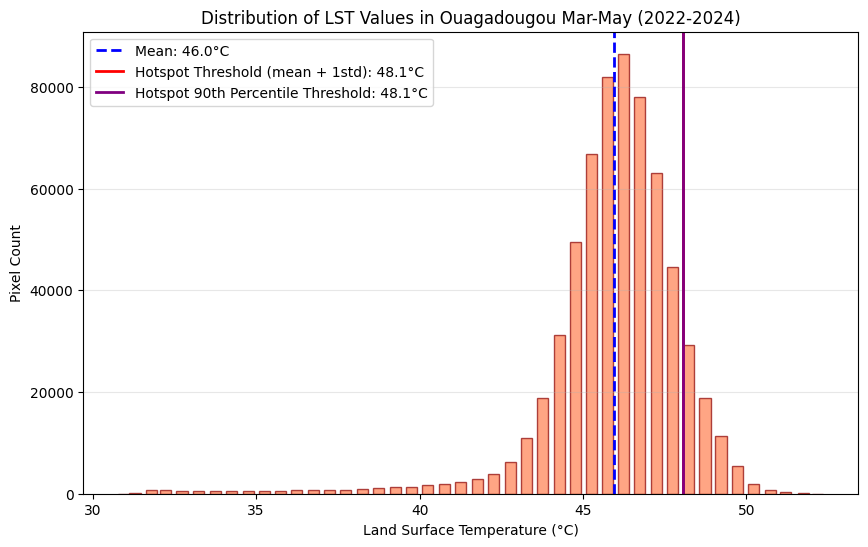

In [10]:
# Get a histogram of LST values within the urban area

# Compute histogram server-side using GEE's reducer
histogram = lst_median.reduceRegion(
    reducer=ee.Reducer.histogram(
        maxBuckets=100,       # Number of bins
        minBucketWidth=0.5    # Minimum bin width in °C
    ),
    geometry=urban,
    scale=30,
    maxPixels=1e13,
    bestEffort=True
)

# Fetch the histogram data
hist_data = histogram.getInfo()['LST']

# Extract the bucket edges and counts
bucket_means = hist_data['bucketMeans']
counts = hist_data['histogram']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bucket_means, counts, width=(bucket_means[1] - bucket_means[0]), 
        color='coral', edgecolor='darkred', alpha=0.7)

# Add vertical lines for mean and threshold
plt.axvline(mean_lst, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_lst:.1f}°C')
plt.axvline(threshold, color='red', linestyle='-', linewidth=2, label=f'Hotspot Threshold (mean + 1std): {threshold:.1f}°C')
p90_thresh_num = p90_thresh.getInfo()
plt.axvline(p90_thresh_num, color='purple', linestyle='-', linewidth=2, label=f'Hotspot 90th Percentile Threshold: {p90_thresh_num:.1f}°C')

plt.xlabel('Land Surface Temperature (°C)')
plt.ylabel('Pixel Count')
plt.title(f'Distribution of LST Values in Ouagadougou {start_month_name}-{end_month_name} ({start_year}-2024)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# EDA

# Check monthly histograms

The 2024 March month had strange values, since several of the images were compromised for various reason (likely sand storms). The histogram originally showed 4 "bumps" instead of anything resembling a normal distribution, which was suspicious. The values were showing as low as 6 degrees Celsius, which would be very strange for that month. Therefore, images from 2022 and 2023 were also included for all months.

Jan: 8 images, LST range: 23.7 - 45.5°C
Feb: 8 images, LST range: 27.4 - 50.2°C
Mar: 5 images, LST range: 5.9 - 54.7°C
Apr: 6 images, LST range: 30.8 - 55.7°C
May: 5 images, LST range: 30.9 - 48.7°C
Jun: 6 images, LST range: 30.5 - 49.1°C
No images for Jul, skipping...
Aug: 2 images, LST range: 10.9 - 45.2°C
No images for Sep, skipping...
Oct: 6 images, LST range: 14.3 - 49.2°C
Nov: 8 images, LST range: 27.4 - 49.0°C
Dec: 8 images, LST range: 23.9 - 45.3°C


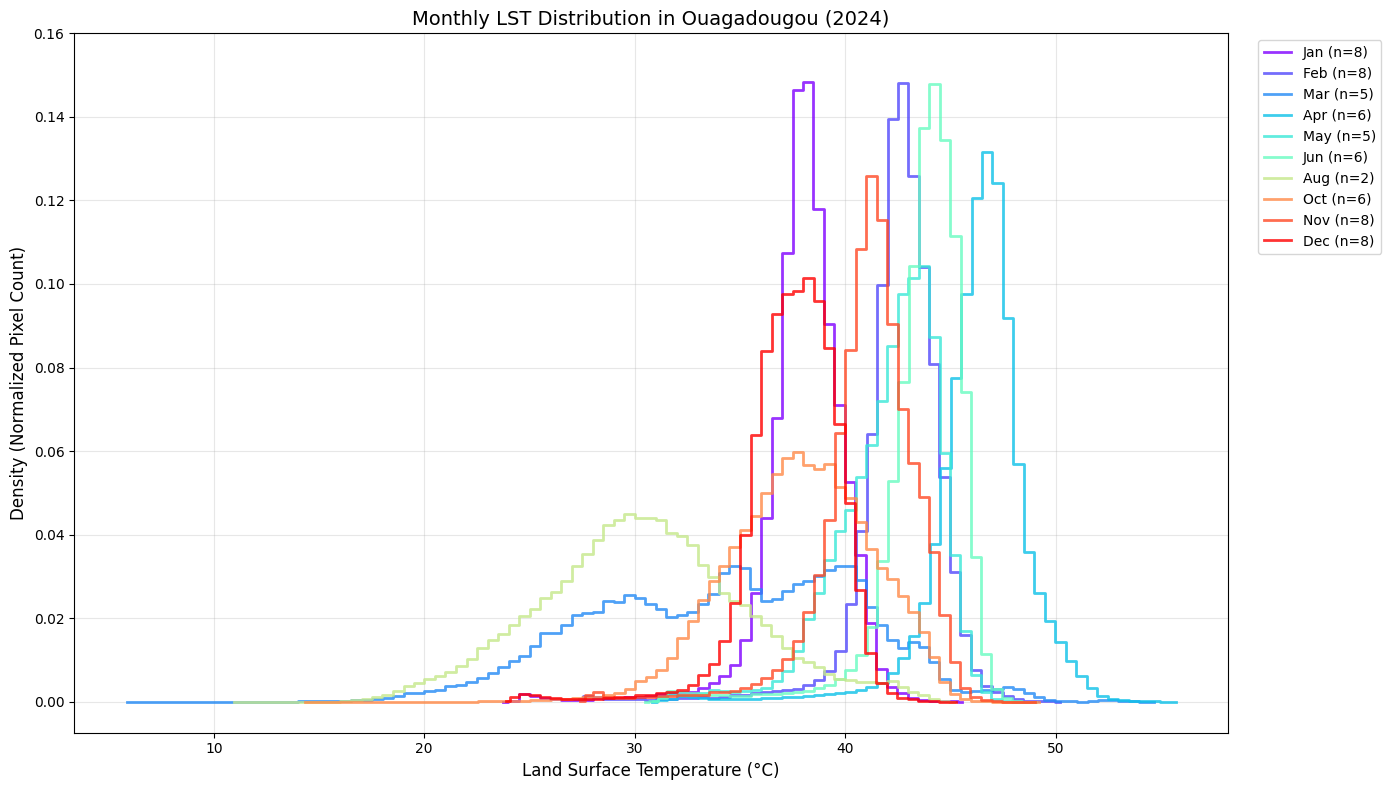

In [11]:
# ==========================================================
# SETUP
# ==========================================================
# west, south, east, north = -1.75, 12.25, -1.35, 12.55
# urban = ee.Geometry.BBox(west, south, east, north)

# Load landsat collections
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

# Base collection
base_collection = (
    l8.merge(l9)
    .filterBounds(urban)
    .filterDate('2024-01-01', '2024-12-31') # Full year of 2024
    .filter(ee.Filter.lt('CLOUD_COVER', 20))
    .map(process_landsat)
)

# ==========================================================
# CREATE MONTHLY COMPOSITES AND EXTRACT HISTOGRAMS
# ==========================================================
# Store histogram data for each month in a dictionary
monthly_histograms = {}

# Define month names for labeling
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Loop through each month (1-12)
for month in range(1, 13):
    # Filter to just this calendar month (across both years)
    monthly_collection = base_collection.filter(
        ee.Filter.calendarRange(month, month, 'month')
    )
    
    # Check if there are images for this month
    count = monthly_collection.size().getInfo()
    if count == 0:
        print(f"No images for {month_names[month-1]}, skipping...")
        continue
    
    # Create median composite for this month
    monthly_median = monthly_collection.median().clip(urban)
    
    # Compute histogram for this month
    histogram = monthly_median.select('LST').reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=100, minBucketWidth=0.5),
        geometry=urban,
        scale=30,
        maxPixels=1e13,
        bestEffort=True
    )
    
    # Fetch histogram data
    hist_data = histogram.getInfo()['LST']
    
    # Store the results
    monthly_histograms[month] = {
        'name': month_names[month-1],
        'bucket_means': hist_data['bucketMeans'],
        'counts': hist_data['histogram'],
        'image_count': count
    }
    
    print(f"{month_names[month-1]}: {count} images, "
          f"LST range: {min(hist_data['bucketMeans']):.1f} - {max(hist_data['bucketMeans']):.1f}°C")

# ==========================================================
# PLOT ALL MONTHS ON THE SAME HISTOGRAM
# ==========================================================
# Use a colormap to give each month a distinct color
cmap = plt.cm.get_cmap('rainbow', 12)

fig, ax = plt.subplots(figsize=(14, 8))

for month, data in monthly_histograms.items():
    # Normalize counts to show as density (easier to compare months with different pixel counts)
    counts_normalized = np.array(data['counts']) / sum(data['counts'])
    
    # Plot as a line (step plot) rather than overlapping bars for clarity
    ax.step(data['bucket_means'], counts_normalized, 
            where='mid', 
            color=cmap(month-1), 
            linewidth=2, 
            alpha=0.8,
            label=f"{data['name']} (n={data['image_count']})")

ax.set_xlabel('Land Surface Temperature (°C)', fontsize=12)
ax.set_ylabel('Density (Normalized Pixel Count)', fontsize=12)
ax.set_title('Monthly LST Distribution in Ouagadougou (2024)', fontsize=14)
ax.set_ylim(ymax=0.16)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(axis='both', alpha=0.3)

plt.tight_layout()
plt.show()

No images for Jan, skipping...
No images for Feb, skipping...
Mar: 5 images, LST range: 5.9 - 54.7°C
Apr: 6 images, LST range: 30.8 - 55.7°C
May: 5 images, LST range: 30.9 - 48.7°C
Jun: 6 images, LST range: 30.5 - 49.1°C
No images for Jul, skipping...
No images for Aug, skipping...
No images for Sep, skipping...
No images for Oct, skipping...
No images for Nov, skipping...
No images for Dec, skipping...


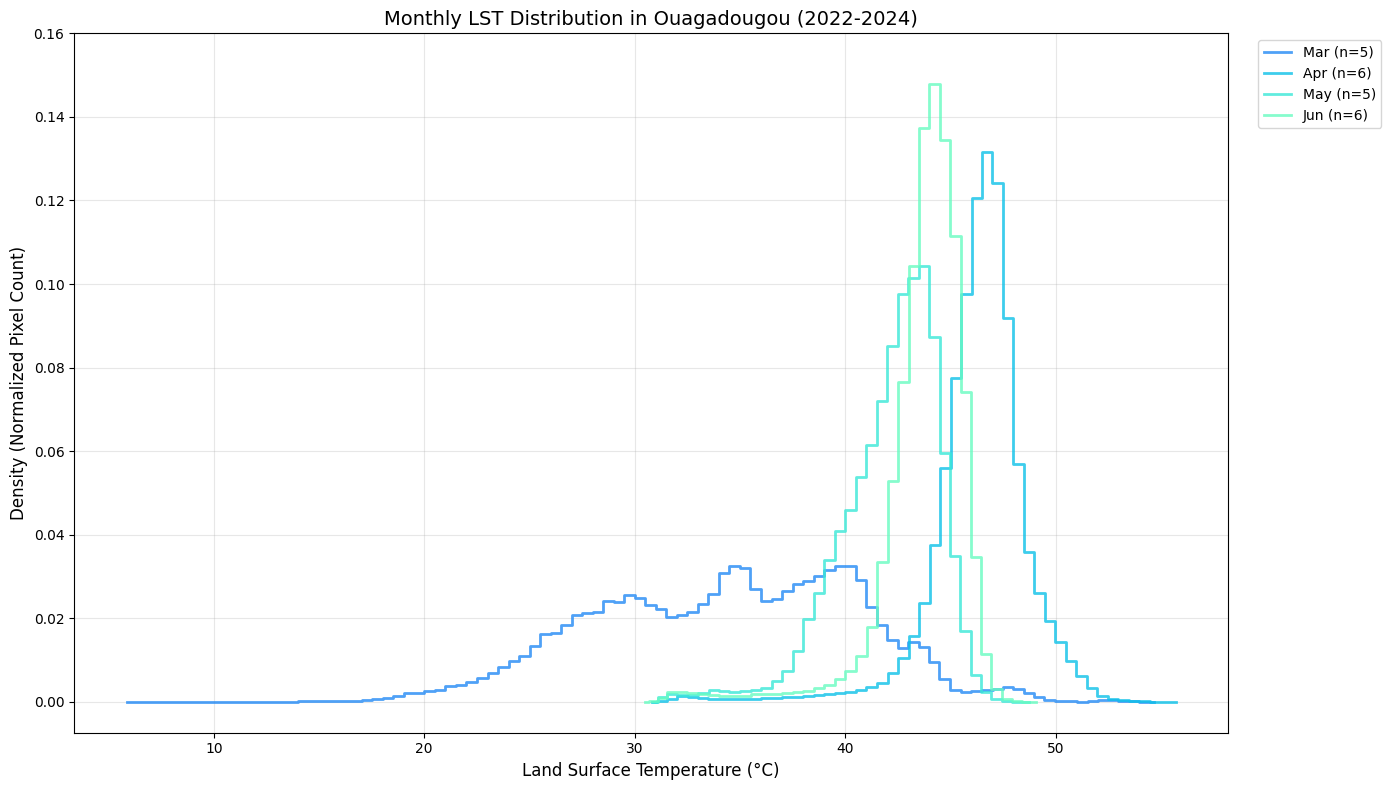

In [12]:
# ==========================================================
# 1. SETUP
# ==========================================================
# west, south, east, north = -1.75, 12.25, -1.35, 12.55
# urban = ee.Geometry.BBox(west, south, east, north)


l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

# Base collection
base_collection = (
    l8.merge(l9)
    .filterBounds(urban)
    .filterDate(f'2024-03-01', '2024-06-30')
    .filter(ee.Filter.lt('CLOUD_COVER', 20))
    .filter(ee.Filter.calendarRange(3, 6, 'month'))  # Filter for the HOT SEASON (March - May for Ouagadougou; we only want to map heat stress, not rainy season cooling)
    # .filter(ee.Filter.date('2024-03-07').Not())  # Exclude the bad date
    # .map(process_landsat_strict)
    .map(process_landsat)
)

# # Filter out suspiciously cold scenes
# base_collection = (
#     l8.merge(l9)
#     .filterBounds(urban)
#     .filterDate('2024-03-01', '2024-06-30')
#     .filter(ee.Filter.lt('CLOUD_COVER', 20))
#     .map(process_landsat_with_temp_filter)
#     .filter(ee.Filter.gt('median_LST', 35))  # Keep only scenes with median > 35°C
# )

# ==========================================================
# 2. CREATE MONTHLY COMPOSITES AND EXTRACT HISTOGRAMS
# ==========================================================
# Store histogram data for each month in a dictionary
monthly_histograms = {}

# Define month names for labeling
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Loop through each month (1-12)
for month in range(1, 13):
    # Filter to just this calendar month (across both years)
    monthly_collection = base_collection.filter(
        ee.Filter.calendarRange(month, month, 'month')
    )
    
    # Check if there are images for this month
    count = monthly_collection.size().getInfo()
    if count == 0:
        print(f"No images for {month_names[month-1]}, skipping...")
        continue
    
    # Create median composite for this month
    monthly_median = monthly_collection.median().clip(urban)
    
    # Compute histogram for this month
    histogram = monthly_median.select('LST').reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=100, minBucketWidth=0.5),
        geometry=urban,
        scale=30,
        maxPixels=1e13,
        bestEffort=True
    )
    
    # Fetch histogram data
    hist_data = histogram.getInfo()['LST']
    
    # Store the results
    monthly_histograms[month] = {
        'name': month_names[month-1],
        'bucket_means': hist_data['bucketMeans'],
        'counts': hist_data['histogram'],
        'image_count': count
    }
    
    print(f"{month_names[month-1]}: {count} images, "
          f"LST range: {min(hist_data['bucketMeans']):.1f} - {max(hist_data['bucketMeans']):.1f}°C")

# ==========================================================
# 3. PLOT ALL MONTHS ON THE SAME HISTOGRAM
# ==========================================================
# Use a colormap to give each month a distinct color
cmap = plt.cm.get_cmap('rainbow', 12)

fig, ax = plt.subplots(figsize=(14, 8))

for month, data in monthly_histograms.items():
    # Normalize counts to show as density (easier to compare months with different pixel counts)
    counts_normalized = np.array(data['counts']) / sum(data['counts'])
    
    # Plot as a line (step plot) rather than overlapping bars for clarity
    ax.step(data['bucket_means'], counts_normalized, 
            where='mid', 
            color=cmap(month-1), 
            linewidth=2, 
            alpha=0.8,
            label=f"{data['name']} (n={data['image_count']})")

ax.set_xlabel('Land Surface Temperature (°C)', fontsize=12)
ax.set_ylabel('Density (Normalized Pixel Count)', fontsize=12)
ax.set_title(f'Monthly LST Distribution in Ouagadougou ({start_year}-2024)', fontsize=14)
ax.set_ylim(ymax=0.16)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(axis='both', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# For each month's median image, count how many valid (non-masked) pixels exist and compute the ranges
for month in range(3, 7):  # March through June
    monthly_collection = base_collection.filter(
        ee.Filter.calendarRange(month, month, 'month')
    )
    monthly_median = monthly_collection.median().clip(urban)
    
    # Count valid pixels (non-null LST values)
    valid_pixel_count = monthly_median.select('LST').reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=urban,
        scale=30,
        maxPixels=1e13
    ).getInfo()
    
    # Also check the min/max to see if there are outliers
    minmax = monthly_median.select('LST').reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=urban,
        scale=30,
        maxPixels=1e13
    ).getInfo()
    
    print(f"{month_names[month-1]}: {valid_pixel_count['LST']:,} valid pixels, "
          f"LST range: {minmax['LST_min']:.1f} - {minmax['LST_max']:.1f}°C")

Mar: 629,302 valid pixels, LST range: 5.7 - 54.5°C
Apr: 630,301 valid pixels, LST range: 30.6 - 55.9°C
May: 630,301 valid pixels, LST range: 30.5 - 48.9°C
Jun: 630,301 valid pixels, LST range: 30.5 - 49.1°C


In [14]:
# Check image names and flyover dates/times for Match

# Filter to just March
march_collection = base_collection.filter(ee.Filter.calendarRange(3, 3, 'month'))

# Get detailed info about each image
march_info = march_collection.aggregate_array('system:index').getInfo()
march_dates = march_collection.aggregate_array('system:time_start').getInfo()

print("March images:")
for i, (idx, timestamp) in enumerate(zip(march_info, march_dates)):
    # Convert timestamp to readable date
    from datetime import datetime
    date = datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d-T%H:%M')
    print(f"  {i+1}. {idx} - {date}")

March images:
  1. 1_LC08_195051_20240331 - 2024-03-31-T10:25
  2. 1_LC08_195052_20240331 - 2024-03-31-T10:26
  3. 2_LC09_195051_20240307 - 2024-03-07-T10:26
  4. 2_LC09_195051_20240323 - 2024-03-23-T10:26
  5. 2_LC09_195052_20240307 - 2024-03-07-T10:26


In [15]:
# Visually inspect suspiciously cold pixels in March

# Filter to just March
march_collection = base_collection.filter(ee.Filter.calendarRange(3, 3, 'month'))

# # Filter to just March, EXCLUDING March 7
# march_collection = base_collection.filter(
#     ee.Filter.calendarRange(3, 3, 'month')
# ).filter(
#     ee.Filter.date('2024-03-07', '2024-03-08').Not()  # Exclude March 7
# )

# Create March median
march_median = march_collection.median().clip(urban)

# Create a mask showing suspiciously cold pixels
cold_threshold = 30
cold_pixels = march_median.select('LST').lt(cold_threshold).selfMask()

# Visualize
Map2 = geemap.Map()
Map2.setCenter(-1.45, 12.345, 11)
Map2.add_basemap('Esri.WorldImagery')

# Show March LST
palette = cm.get_palette('inferno')
Map2.addLayer(march_median.select('LST'), 
              {'min': 5, 'max': 55, 'palette': palette}, 
              'March Median LST')

# Highlight cold pixels in blue
Map2.addLayer(cold_pixels, {'palette': ['blue']}, 'Suspiciously Cold Pixels (<30°C)')

Map2.add_colorbar({'min': 5, 'max': 55, 'palette': palette}, label='LST (°C)')
Map2

Map(center=[12.345, -1.45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
Map2.to_html('../../figures/map_median_lst_march_2024.html', title="")
# geemap.show_html('../../figures/map_median_lst_march_2024.html')
# HTML(filename='../../figures/map_median_lst_march_2024.html')

In [17]:
# Display LST in a way that renders on GitHub
thumb_url2 = march_median.getThumbUrl({
    'min': 25,
    'max': 60,
    'palette': ['000004', '320A5A', '781C6D', 'BC3754', 'ED6925', 'F9B641', 'FCFFA4'],
    'dimensions': 800,
    'region': urban
})

Image(url=thumb_url2)

In [18]:
# Create a map to view each March image separately (to inspect anomalies)

# # Filter to just March, EXCLUDING March 7
# march_collection = base_collection.filter(
#     ee.Filter.calendarRange(3, 3, 'month')
# ).filter(
#     ee.Filter.date('2024-03-07', '2024-03-08').Not()  # Exclude March 7
# )

# Get list of March images as an ee.List
march_list = march_collection.toList(march_collection.size())
n_images = march_collection.size().getInfo()

# Create a map to view each image separately
Map3 = geemap.Map()
Map3.setCenter(-1.45, 12.345, 11)
Map3.add_basemap('Esri.WorldImagery')

# Add each March image as a separate toggleable layer
for i in range(n_images):
    img = ee.Image(march_list.get(i))
    
    # Get the image ID and date for the layer name
    img_id = img.get('system:index').getInfo()
    timestamp = img.get('system:time_start').getInfo()
    date_str = datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')
    
    # Extract path/row from the ID (format: "1_LC08_195051_20240331")
    # The "195051" part = path 195, row 051
    path_row = img_id.split('_')[2]  # Gets "195051" from "_" split string
    
    # Create a descriptive layer name
    layer_name = f"{date_str} ({path_row})"
    
    # Add to map - only show the first one by default, others are hidden
    Map3.addLayer(
        img.select('LST').clip(urban), 
        {'min': 5, 'max': 55, 'palette': palette}, 
        layer_name,
        shown=(i == 0)  # Only first layer visible by default
    )

# Add a colorbar for reference
Map3.add_colorbar({'min': 5, 'max': 55, 'palette': palette}, label='LST (°C)')
Map3

Map(center=[12.345, -1.45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
Map3.to_html('../../figures/map_lst_march_days_2024.html', title="")
geemap.show_html('../../figures/map_lst_march_days_2024.html')
# HTML(filename='../../figures/map_lst_march_days_2024.html')

In [20]:
# Display LST in a way that renders on GitHub
img = ee.Image(march_list.get(0)).select('LST').clip(urban)
timestamp = img.get('system:time_start').getInfo()
date_str = datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')
thumb_url3 = img.getThumbUrl({
    'min': 5,
    'max': 60,
    'palette': ['000004', '320A5A', '781C6D', 'BC3754', 'ED6925', 'F9B641', 'FCFFA4'],
    'dimensions': 800,
    'region': urban
})
print(f'Date image was collected: {date_str}')
Image(url=thumb_url3)

Date image was collected: 2024-03-31


In [21]:
# Display LST in a way that renders on GitHub
img = ee.Image(march_list.get(4)).select('LST').clip(urban)
timestamp = img.get('system:time_start').getInfo()
date_str = datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')
thumb_url3 = img.getThumbUrl({
    'min': 5,
    'max': 60,
    'palette': ['000004', '320A5A', '781C6D', 'BC3754', 'ED6925', 'F9B641', 'FCFFA4'],
    'dimensions': 800,
    'region': urban
})
print(f'Date image was collected: {date_str}')
Image(url=thumb_url3)

Date image was collected: 2024-03-07


# Extra

In [22]:
from geemap import chart

lst = lst_median.select('LST')


fig = chart.image_histogram(
    image=lst,
    region=urban,
    scale=30,
    max_buckets=60,          # number of bins (roughly)
    min_bucket_width=None,   # optionally force a bin width
    max_pixels=1e13,
    max_raw=1000,
    title='Distribution of LST Values in Ouagadougou (Hot Season)'
)
fig


Figure(axes=[Axis(label='Reflectance (x1e4)', scale=LinearScale(), tick_format='0.0f'), Axis(label='Count', or…